## 如何实现拒答

1. 把所有该拒答和不该拒答的问题收集起来（没有数据的时候，mock一部分问题）
2. 计算这些问题与知识库里面的相似分数分布
   1. 倒排方面，查看倒排得分逻辑，优化不合理得分
   2. 向量方面，如果与正反馈的分数分布区分明显，直接找到该阈值，否则跳到下一步
3. 拿上面两种进行向量微调，再次查看分数分布区分度，如果不合格再跳转到下一步
4. 拿上面两种进行Rerank，再次查看分数分布区分度
5. 如果区分度还存在问题，低风险分段进行提示词次软性拒答，高风险分段进行硬性拒答

In [ ]:
!pip install boto3
!pip install git+https://github.com/FlagOpen/FlagEmbedding.git -Uq
!pip install -Uq sentence-transformers 
!pip install faiss-cpu -Uq

### Step 1 整理全部应该拒答的问题

In [9]:
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
from boto3 import client as boto3_client
import boto3
import os
import numpy as np
from tqdm import tqdm

Tune_Specified_Chat_Name = 'OnlyForDEBUG'
smr_client = boto3.client("sagemaker-runtime")
embedding_endpoint_name = 'bge-zh-15-2023-09-17-01-00-27-086-endpoint'

lambda_client = boto3_client('lambda')

def generate_train_dataset(query, embedding_endpoint_name):
    data = {
        'OPENAI_API_KEY': '', 
        'ws_endpoint': 'https://7bk6ty9c65.execute-api.us-west-2.amazonaws.com/Prod', 
        'msgid': 'id-1695293211608-da6836af1c57_res', 
        'chat_name': Tune_Specified_Chat_Name, 
        'prompt': query, 
        'model': 'chatglm', 
        'use_qa': True, 
        'imgurl': None, 
        'template_id': 'default', 
        'max_tokens': 4000, 
        'temperature': 0.01, 
        'system_role': 'AWSBot', 
        'system_role_prompt': '你是亚马逊云科技的智能客服', 
        'embedding_model': embedding_endpoint_name,
        'channel_cnt' : 100
    }

    invoke_response = lambda_client.invoke(FunctionName='Ask_Assistant', 
                                           InvocationType='RequestResponse',
                                           Payload=json.dumps(data))
    ret_obj = json.loads(invoke_response['Payload'].read().decode('utf-8'))
    if 'body' not in ret_obj.keys():
        print(ret_obj)
    info = ret_obj['body'][0]['extra_info']
    query = info['query_input']
    bm25_infos = info['opensearch_query_response']
    bm25_scores = [ item['score'] for item in bm25_infos ] 
    knn_infos = info['opensearch_knn_respose']

    bm25_negs = []
    knn_negs = []
    knn_qq_negs = []
    knn_qd_negs = []
    knn_qq_scores = []
    knn_qd_scores = []
    for item in knn_infos:
        knn_negs.append(item['doc'])
        mid = item['doc'].split('Answer: ')
        q = mid[0].split('Question: ')[1]
        a = mid[1]
        
        if item['doc_type'] == 'Question':
            knn_qq_negs.append(q)
            knn_qq_scores.append(item['score'])
        elif item['doc_type'] == 'Paragraph':
            knn_qd_negs.append(a)
            knn_qd_scores.append(item['score'])
    
    for item in bm25_infos:
        bm25_negs.append(item['doc'])
    
    return query, bm25_negs, bm25_scores, knn_qq_negs, knn_qq_scores, knn_qd_negs, knn_qd_scores

# query, bm25_negs, bm25_scores, knn_qq_negs, knn_qq_scores, knn_qd_negs, knn_qd_scores = generate_train_dataset(query, embedding_endpoint_name)

def get_vector_by_sm_endpoint(questions, sm_client, endpoint_name, instruction=''):
    response_model = sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "inputs": questions,
                "is_query": True,
                "instruction" :  instruction,
                "parameters" : ""
            }
        ),
        ContentType="application/json",
    )
    # 中文instruction => 为这个句子生成表示以用于检索相关文章：
    # English instruction => Represent this sentence for searching relevant passages:
    json_str = response_model['Body'].read().decode('utf8')
    json_obj = json.loads(json_str)
    embeddings = json_obj['sentence_embeddings']
    return embeddings[0]

def similarity_calc(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.sqrt(np.dot(vec1, vec1))
    norm_vec2 = np.sqrt(np.dot(vec2, vec2))
    cosine_sim = dot_product / (norm_vec1 * norm_vec2)
    
    return cosine_sim

def get_similiarity(sent1, sent2):
    vec1 = get_vector_by_sm_endpoint(sent1, smr_client, embedding_endpoint_name)
    vec2 = get_vector_by_sm_endpoint(sent2, smr_client, embedding_endpoint_name)
    return similarity_calc(vec1, vec2)

def plot_stat(pos_similarity_list, neg_similarity_list):
    
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    L1 = len(pos_similarity_list)
    L2 = len(neg_similarity_list)
    if L1 > L2:
        sample_neg_similarity_list = random.sample(neg_similarity_list, L2)
        sample_pos_similarity_list = pos_similarity_list
    else:
        sample_neg_similarity_list = neg_similarity_list
        sample_pos_similarity_list = random.sample(pos_similarity_list, L1)
    
    sns.histplot(data=sample_pos_similarity_list, bins=20)
    sns.histplot(data=sample_neg_similarity_list, bins=20)
    
    # plt.tight_layout()
    plt.show()

In [16]:
all_neg_bm25_scores = []
all_neg_knn_qq_scores = []
all_neg_knn_qd_scores = []

neg_feedback_qa_triple = []
neg_feedback_qq_triple = []

# mock out_of_range question
with open('aws_glue.faq') as mock_outofrange_faq:
    all_content = mock_outofrange_faq.read()
    qa_list = all_content.split('=====')
    for qa in tqdm(qa_list):
        parts = qa.split('\nAnswer: ')
        q = parts[0].split('Question: ')[1]
        a = parts[1]
        query, bm25_negs, bm25_scores, knn_qq_negs, knn_qq_scores, knn_qd_negs, knn_qd_scores = generate_train_dataset(q, embedding_endpoint_name)
        all_neg_bm25_scores.extend(bm25_scores)
        all_neg_knn_qq_scores.extend(knn_qq_scores)
        all_neg_knn_qd_scores.extend(knn_qd_scores)
        neg_feedback_qa_triple.append({"query":q, "pos": [a], "neg": bm25_negs + knn_qd_negs})
        neg_feedback_qq_triple.append({"query":q, "pos": [], "neg": knn_qq_negs})

100%|██████████| 72/72 [00:44<00:00,  1.63it/s]


In [17]:
#mock questionable question
all_pos_knn_qq_scores = []
all_pos_knn_qd_scores = []

with open('aws_emr_offical.json') as mock_normal_qlist:
    lines = mock_normal_qlist.readlines()
    for line in lines:
        json_obj = json.loads(line)
        o_query = json_obj['origin_question'].strip()
        o_answer = json_obj['origin_answer'].strip()
        g_query = json_obj['generate_question'].strip()
        g_answer = json_obj['generate_answer'].strip()
        
        sim_qq = get_similiarity(g_query, o_query)
        sim_qa1 = get_similiarity(g_query, o_answer)
        sim_qa2 = get_similiarity(g_query, g_answer)
        sim_qa3 = get_similiarity(o_query, o_answer)
        all_pos_knn_qq_scores.append(sim_qq)
        all_pos_knn_qd_scores.append(sim_qa1)
        all_pos_knn_qd_scores.append(sim_qa2)
        all_pos_knn_qd_scores.append(sim_qa3)

In [ ]:
print(f"len of all_pos_knn_qq_scores: {len(all_pos_knn_qq_scores)}")
print(all_pos_knn_qq_scores[:20])
print(f"len of all_neg_knn_qq_scores: {len(all_neg_knn_qq_scores)}")
print(all_neg_knn_qq_scores[:20])
print(f"len of all_pos_knn_qd_scores: {len(all_pos_knn_qd_scores)}")
print(all_pos_knn_qd_scores[:20])
print(f"len of all_neg_knn_qd_scores: {len(all_neg_knn_qd_scores)}")
print(all_neg_knn_qd_scores[:20])

print(f"len of neg_feedback_qq_triple: {len(neg_feedback_qq_triple)}")
print(neg_feedback_qq_triple[:20])

### Step2 统计分数分布

In [ ]:
plot_stat(all_pos_knn_qq_scores, all_neg_knn_qq_scores)
plot_stat(all_pos_knn_qd_scores, all_neg_knn_qd_scores)

### Step3 构建Finetune 数据集

### 构造finetune数据集
- 如果没有QQ数据集，通过LLM给query换个提问角度,得到 query_mock
- 如果没有QD数据集，通过LLM给query给出一个回答,得到 answer_mock
- 融合知识库里面现有的问答，得到供训练的所需正负例
    + (instruction+query, answer_mock, all_retrival_neg_answers)
    + (query, query_mock, all_retrival_neg_querys)

In [24]:
import boto3
import json
from tqdm import tqdm
llm_endpoint_name='bc2-7b-stream-2023-09-21-10-07-30-023-endpoint'
smr_client = boto3.client("sagemaker-runtime")

def mock_qq_dataset(llm_endpoint_name, smr_client, neg_feedback_qq_triple):
    mock_query_template="""给问题"{}"生成一个相似的问题"""
    parameters = {
      "max_length": 1024,
      "temperature": 0.99,
      "top_p":0.99
    }
    
    def call_llm(prompt, smr_client):
        response_model = smr_client.invoke_endpoint(
                    EndpointName=llm_endpoint_name,
                    Body=json.dumps(
                    {
                        "inputs": prompt,
                        "parameters": parameters,
                        "history" : []
                    }
                    ),
                    ContentType="application/json",
                )

        json_obj=json.loads(response_model['Body'].read().decode('utf8'))
        return json_obj['outputs']
    

    for example_obj in tqdm(neg_feedback_qq_triple):
        prompt = mock_query_template.format(example_obj['query'])
        example_obj["pos"] = [ call_llm(prompt, smr_client).strip('"')]
        
    return neg_feedback_qq_triple

In [25]:
neg_feedback_qq_triple = mock_qq_dataset(llm_endpoint_name, smr_client, neg_feedback_qq_triple)

100%|██████████| 72/72 [00:44<00:00,  1.61it/s]


In [ ]:
neg_feedback_qq_triple[0]

In [29]:
data_size = len(neg_feedback_qq_triple)
qq_train_data_set = neg_feedback_qq_triple[:int(data_size*0.9)]
qq_test_data_set =  neg_feedback_qq_triple[int(data_size*0.9):]

if not os.path.exists('./trainset'):
    os.mkdir('./trainset')
if not os.path.exists('./testset'):
    os.mkdir('./testset')

with open('./trainset/refuse_trainset.jsonl', 'w') as file1:
    lines = [ json.dumps(example, ensure_ascii=False) for example in qq_train_data_set ]
    file1.write("\n".join(lines))
    
with open('./testset/refuse_testset.jsonl', 'w') as file2:
    lines = [ json.dumps(example, ensure_ascii=False) for example in qq_test_data_set ]
    file2.write("\n".join(lines))
    
knowledgebase_qq_triple = []
knowledgebase_gqoa_triple = []
knowledgebase_gqga_triple = []
all_g_q = []
all_o_a = []
all_g_a = []

with open('aws_emr_offical.json') as mock_normal_qlist:
    lines = mock_normal_qlist.readlines()
    for idx, line in enumerate(lines):
        json_obj = json.loads(line)
        o_query = json_obj['origin_question'].strip()
        o_answer = json_obj['origin_answer'].strip()
        g_query = json_obj['generate_question'].strip()
        g_answer = json_obj['generate_answer'].strip()
        all_g_q.append(g_query)
        all_o_a.append(o_answer)
        all_g_a.append(g_answer)
        knowledgebase_qq_triple.append({"query": o_query, "pos": [g_query], "neg" : idx})
        knowledgebase_gqoa_triple.append({"query": g_query, "pos": [o_answer], "neg" : idx})
        knowledgebase_gqga_triple.append({"query": g_query, "pos": [g_answer], "neg" : idx})
        
kg_data_size = len(knowledgebase_qq_triple)
train_cnt = int(kg_data_size*0.9)
print(f"train_cnt: {train_cnt}")

for idx in range(kg_data_size):
    knowledgebase_qq_triple[idx]["neg"] = all_g_q[:idx] + all_g_q[idx+1:]
    knowledgebase_gqoa_triple[idx]["neg"] = all_o_a[:idx] + all_o_a[idx+1:]
    knowledgebase_gqga_triple[idx]["neg"] = all_g_a[:idx] + all_g_a[idx+1:]
    
with open('./trainset/kg_qq_trainset.jsonl', 'w') as file3:
    lines = [ json.dumps(example, ensure_ascii=False) for example in knowledgebase_qq_triple[:train_cnt] ]
    file3.write("\n".join(lines))
    
with open('./testset/kg_qq_testset.jsonl', 'w') as file4:
    lines = [ json.dumps(example, ensure_ascii=False) for example in knowledgebase_qq_triple[train_cnt:] ]
    file4.write("\n".join(lines))
    
with open('./trainset/kg_gqoa_trainset.jsonl', 'w') as file5:
    lines = [ json.dumps(example, ensure_ascii=False) for example in knowledgebase_gqoa_triple[:train_cnt] ]
    file5.write("\n".join(lines))
    
with open('./testset/kg_gqoa_testset.jsonl', 'w') as file6:
    lines = [ json.dumps(example, ensure_ascii=False) for example in knowledgebase_gqoa_triple[train_cnt:] ]
    file6.write("\n".join(lines))
    
with open('./trainset/kg_gqga_trainset.jsonl', 'w') as file7:
    lines = [ json.dumps(example, ensure_ascii=False) for example in knowledgebase_gqga_triple[:train_cnt] ]
    file7.write("\n".join(lines))
    
with open('./testset/kg_gqga_testset.jsonl', 'w') as file8:
    lines = [ json.dumps(example, ensure_ascii=False) for example in knowledgebase_gqga_triple[train_cnt:] ]
    file8.write("\n".join(lines))

train_cnt: 963


In [30]:
len(knowledgebase_gqga_triple)

1070

### step4 Finetune Rerank

In [23]:
!cat ./trainset/*.jsonl > trainset/kg_merged.jsonl

In [ ]:
!wc -l trainset/kg_merged.jsonl

In [ ]:
!cat ./testset/kg_*.jsonl > ./testset/kg_merged.jsonl

In [ ]:
!wc -l testset/kg_merged.jsonl

In [ ]:
!torchrun --nproc_per_node 1 \
-m FlagEmbedding.reranker.run \
--output_dir ./refuse_rerank_bge_base_zh15 \
--model_name_or_path BAAI/bge-reranker-base \
--train_data ./trainset \
--learning_rate 6e-5 \
--fp16 \
--num_train_epochs 3 \
--per_device_train_batch_size 1 \
--gradient_accumulation_steps 4 \
--dataloader_drop_last True \
--train_group_size 9 \
--max_len 512 \
--weight_decay 0.01 \
--logging_steps 100

In [ ]:
from FlagEmbedding import FlagReranker
reranker = FlagReranker('./refuse_rerank_bge_base_zh15', use_fp16=True)

scores = reranker.compute_score([['什么是 AWS Glue？', 'AWS Glue 是一项无服务器数据集成服务，它简化了发现、准备和合并数据以进行分析、机器学习和应用程序开发的工作。 AWS Glue 提供数据集成所需的全部功能，使您只需几分钟时间便可以开始分析数据并将数据投入使用，而不用耗时几个月。AWS Glue 为您提供可视化界面和基于代码的界面来简化数据集成。用户使用 AWS Glue 数据目录可以轻松找到并访问数据。数据工程师和 ETL（即提取、转换和加载）开发人员只需在 AWS Glue Studio 中点击几次，便能够以可视化的方式创建、运行和监控 ETL 工作流程。数据分析师和数据科学家可以使用 AWS Glue DataBrew 可视化方式丰富、清理和标准化数据，而无需编写代码。']])
print(scores)

Compute Scores: 100%|██████████| 24/24 [00:08<00:00,  2.95it/s]


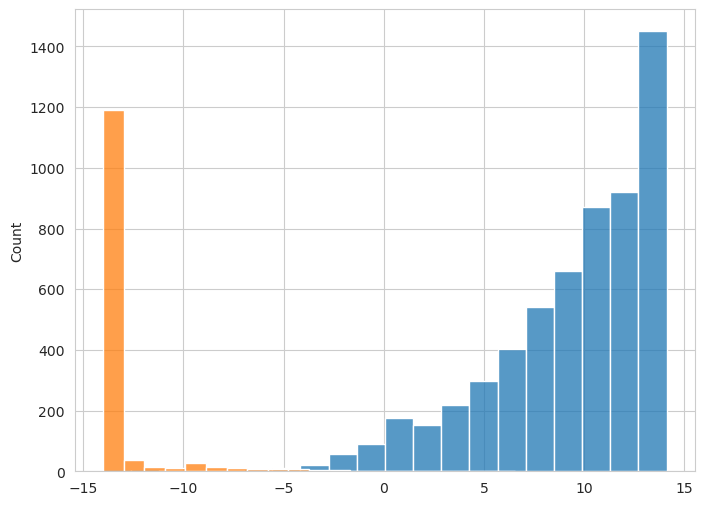

In [27]:
train_neg_scores_after_rank = []
train_pos_scores_after_rank = []

with open('./trainset/kg_merged.jsonl', 'r') as p_t_file:
    lines = p_t_file.readlines()
    pos_pair_list = []
    for line in lines:
        try:
            json_obj = json.loads(line)
        except Exception as e:
            continue
        query = json_obj['query'].strip()
        pos = json_obj['pos'][0].strip()
        pos_pair_list.append([query, pos])
    pos_scores = reranker.compute_score(pos_pair_list)
    train_pos_scores_after_rank.extend(pos_scores)

with open('./trainset/refuse_trainset.jsonl', 'r') as n_t_file:
    lines = n_t_file.readlines()
    for line in lines:
        obj = json.loads(line)
        neg_pair_list = [ [obj['query'].strip(), neg.strip()] for neg in obj['neg'] ]
        neg_scores = reranker.compute_score(neg_pair_list)
        train_neg_scores_after_rank.extend(neg_scores)
        
plot_stat(train_pos_scores_after_rank, train_neg_scores_after_rank)

In [28]:
test_neg_scores_after_rank = []
test_pos_scores_after_rank = []

with open('./testset/kg_merged.jsonl', 'r') as p_t_file:
    lines = p_t_file.readlines()
    pos_pair_list = []
    for line in lines:
        try:
            json_obj = json.loads(line)
        except Exception as e:
            continue
        query = json_obj['query'].strip()
        pos = json_obj['pos'][0].strip()
        pos_pair_list.append([query, pos])
    pos_scores = reranker.compute_score(pos_pair_list)
    test_pos_scores_after_rank.extend(pos_scores)

with open('./testset/refuse_testset.jsonl', 'r') as n_t_file:
    lines = n_t_file.readlines()
    for line in lines:
        obj = json.loads(line)
        neg_pair_list = [ [obj['query'].strip(), neg.strip()] for neg in obj['neg'] ]
        neg_scores = reranker.compute_score(neg_pair_list)
        test_neg_scores_after_rank.extend(neg_scores)

Compute Scores: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


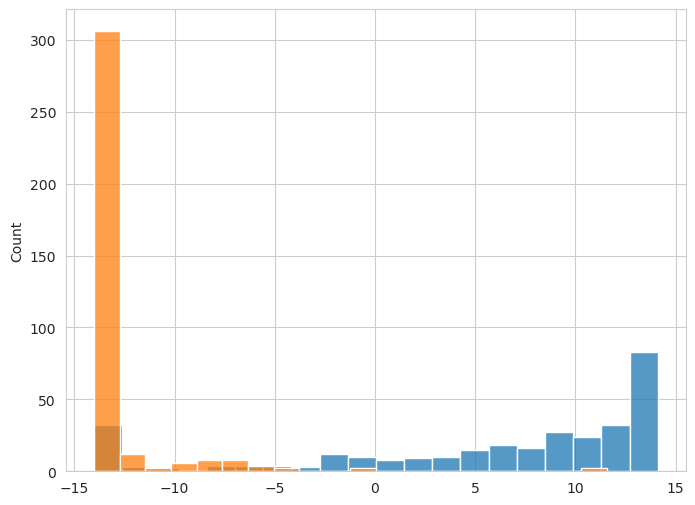

In [22]:
plot_stat(test_pos_scores_after_rank, test_neg_scores_after_rank)